# Simulating circuits

## Overview

Quantum circuits can be simulated using three different backend formalisms: density matrix, stabilizer, and graph state. 
The backend classical simulation of the quantum circuit is done by the `Compiler` classes, including `DensityMatrixCompiler` and `StabilizerCompiler`.
However, operations on the circuit are restricted when using the stabilizer and graph backends, whereas all implemented gates are supported by the density matrix backend. 

### Simulating using the density matrix backend

In [2]:
""" Initializing a DensityMatrix compiler """
from graphiq.backends.density_matrix.compiler import DensityMatrixCompiler

compiler = DensityMatrixCompiler()  # no argument necessary

4-qubit GHZ - expected state


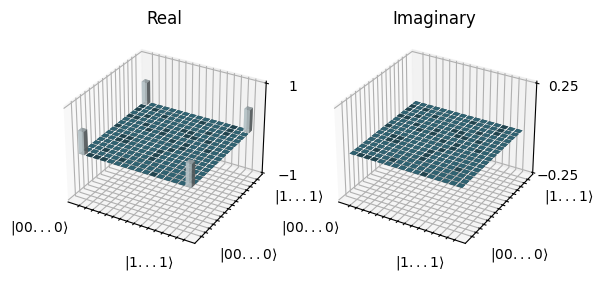

4-qubit GHZ - simulated state


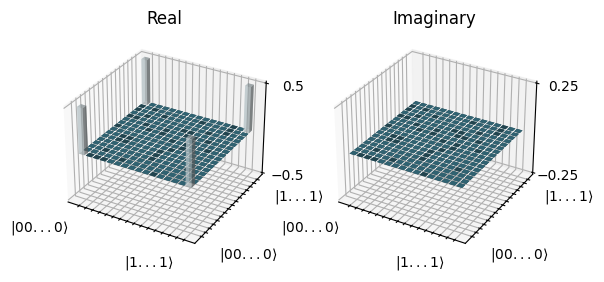

In [5]:
""" Circuit compilation """
from graphiq.benchmarks.circuits import ghz4_state_circuit
import graphiq.backends.density_matrix.functions as dmf

# load an example circuit which generates a 4-qubit GHZ state, and simulate the circuit using the density matrix backend
ghz4_circuit, ghz4_expected = ghz4_state_circuit()

# Compile
output_state = compiler.compile(ghz4_circuit)

# trace out the emitter qubit
output_state.partial_trace(keep=[0, 1, 2, 3], dims=5 * [2])

# Compare expected and retrieved results
print("4-qubit GHZ - expected state")
ghz4_expected.rep_data.draw()

print("4-qubit GHZ - simulated state")
output_state.rep_data.draw();

### Compiler settings
Simulation backends have two main flags: `noise_simulation` a boolean flag which indicates if we want to simulate noise, and `measurement_determinism` which tells us how to simulate probabilistic events.
If `noise_simulation == True`, we simulate all noise operations added to the circuit. If `noise_simulation == False`, all noise is ignored and the ideal (i.e., unitary evolution) is simulated. 
Recall that we have operations in which we a) measure a control qubit, b) save the measurement result to a classical register, and c) use this classical result to control we apply a gate on a target register. This is an example of a probabilistic event (since the control qubit will be measured as 0 with a certain probability, and as 1 the rest of the time).
If `measurement_determinism == 1`, the measurements always return 1 (unless the probability of 1 is zero). If `measurement_determinism == 0`, the measurements always return 0. If `measurement_determinism == "probabilistic"`, 0 and 1 are returned according to the quantum state's probability distribution.


In [8]:
"""
Effects of measurement determinism

We will manually show the effects here, though normally this is built into the compiler
"""

# Let's build a very simple circuit where (with a proper probabilistic treatment) we expect P(0) = P(1) = 1/2
from graphiq.circuit.circuit_dag import CircuitDAG
import graphiq.circuit.ops as ops

circuit = CircuitDAG()
circuit.add(ops.Hadamard(register=0, reg_type="e"))

compiler = DensityMatrixCompiler()


def check_measurement_result_ratio(determinism):
    n_retries = 100
    measurement1_count = 0
    for i in range(n_retries):
        output_state = compiler.compile(circuit)

        # This part happens inside the compiler if we add a MeasurementZ operation. We execute the code manually here
        # such that we can examine the result easily
        projectors = dmf.projectors_zbasis(
            1,  # number of qubits
            0,  # index of the qubit to measure, in the density matrix
        )

        outcome = output_state.rep_data.apply_measurement(
            projectors, measurement_determinism=determinism
        )
        measurement1_count += outcome

    print(
        f"measurement 1 ratio, determinism = {determinism}: {measurement1_count / n_retries}"
    )


# Look at probabilistic results
compiler.measurement_determinism = "probabilistic"
check_measurement_result_ratio(compiler.measurement_determinism)


# Look at measurement_determinism == 1 results
compiler.measurement_determinism = 1
check_measurement_result_ratio(compiler.measurement_determinism)

# Look at measurement_determinism == 0 results
compiler.measurement_determinism = 0
check_measurement_result_ratio(compiler.measurement_determinism)

measurement 1 ratio, determinism = probabilistic: 0.54
measurement 1 ratio, determinism = 1: 1.0
measurement 1 ratio, determinism = 0: 0.0


### Simulating using a stabilizer backend

The `StabilizerCompiler` is initialized and used in the same way as the `DensityMatrixCompiler`, however is constrained to only support stabilizer operations.

In [9]:
""" Initializing a Stabilizer compiler """
from graphiq.backends.stabilizer.compiler import StabilizerCompiler
import graphiq.backends.state_rep_conversion as rc

compiler = StabilizerCompiler()

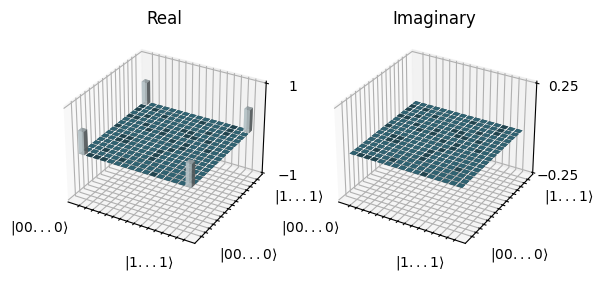

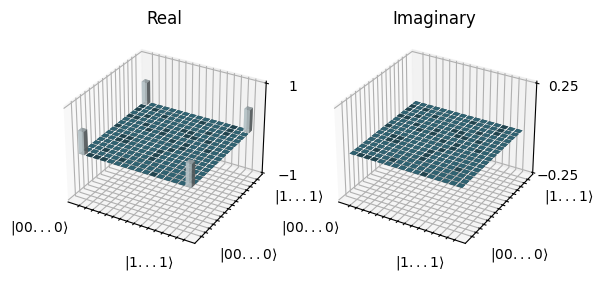

In [10]:
""" Circuit compilation """
from graphiq.benchmarks.circuits import ghz4_state_circuit
from graphiq.backends.stabilizer.state import Stabilizer
from graphiq.backends.density_matrix.state import DensityMatrix

# We can load a circuit from our benchmark set and try compiling it
ghz4_circuit, ghz4_expected = ghz4_state_circuit()
n_photons = 4

# simulate circuit
output_state = compiler.compile(ghz4_circuit)
output_state.partial_trace(keep=[0, 1, 2, 3], dims=5 * [2])


# convert stabilizer to density matrix
output_s_tableau = output_state.rep_data.tableau.to_stabilizer()
output_dm = rc.stabilizer_to_density(output_s_tableau.to_labels())
output_dm = DensityMatrix(output_dm)

# compare expected and simulated states
ghz4_expected.rep_data.draw()
output_dm.draw();

In [11]:
"""
Effects of measurement determinism

We will manually show the effects here, though normally this is built into the compiler
"""

# Let's build a very simple circuit where (with a proper probabilistic treatment) we expect P(0) = P(1) = 1/2
from graphiq.circuit.circuit_dag import CircuitDAG
import graphiq.circuit.ops as ops

circuit = CircuitDAG()
circuit.add(ops.Hadamard(register=0, reg_type="e"))

compiler = StabilizerCompiler()

In [12]:
def check_measurement_result_ratio(determinism):
    n_retries = 1000
    ones_count = 0
    zeros_count = 0

    for i in range(n_retries):
        # compile the circuit to get the state and apply measurement
        output_state = compiler.compile(circuit)
        result = output_state.rep_data.apply_measurement(
            0, measurement_determinism=determinism
        )

        if result == 1:
            ones_count += 1
        else:
            zeros_count += 1

    print(
        f"measurement {determinism}, ones count: {ones_count} - zeros count: {zeros_count}"
    )

In [13]:
# Look at probabilistic results
compiler.measurement_determinism = "probabilistic"
check_measurement_result_ratio(compiler.measurement_determinism)


# Look at measurement_determinism == 1 results
compiler.measurement_determinism = 1
check_measurement_result_ratio(compiler.measurement_determinism)

# Look at measurement_determinism == 0 results
compiler.measurement_determinism = 0
check_measurement_result_ratio(compiler.measurement_determinism)

measurement probabilistic, ones count: 477 - zeros count: 523
measurement 1, ones count: 1000 - zeros count: 0
measurement 0, ones count: 0 - zeros count: 1000
